In [1]:
import music21 as m21
from pathlib import Path
import pickle
import pandas as pd
import json
from collections import Counter

import numpy as np
from matplotlib import pyplot as plt

In [2]:
#helper functions and data structures

pitches_dict = {
    0 : ["C","B#","D--"], # nn.Linear(input_size+context_size, 3)
    1 : ["C#","B##","D-"], # nn.Linear(input_size+context_size, 2)
    2 : ["D","C##","E--"], # nn.Linear(input_size+context_size, 3)
    3 : ["D#","E-","F--"],
    4 : ["E","D##","F-"],
    5 : ["F","E#","G--"],
    6 : ["F#","E##","G-"],
    7 : ["G","F##","A--"],
    8 : ["G#","A-"],
    9 : ["A","G##","B--"],
    10 : ["A#","B-","C--"],
    11 : ["B","A##","C-"]
}

accepted_pitches = [ii for i in pitches_dict.values() for ii in i]
print([e for e in enumerate(accepted_pitches)])

double_acc_pitches = [ii for i in pitches_dict.values() for ii in i if ii.endswith("##") or  ii.endswith("--") ]
print(double_acc_pitches)

def score2midi_numbers(score):
    return [p.midi%12 for n in score.flat.notes for p in n.pitches]

def score2pitches(score):
    return [p.name for n in score.flat.notes for p in n.pitches]

def score2pitches_meredith(score):
    # Return the David Meredith style of pitches (http://www.titanmusic.com/data.php)
    return [p.nameWithOctave.replace("s","#").replace("f","-")
            if ("#" in p.nameWithOctave) or ("-" in p.nameWithOctave)
            else p.nameWithOctave.replace("s","#").replace("f","-")[:-1] + "n" + p.nameWithOctave.replace("s","#").replace("f","-")[-1]
            for n in score.flat.notes for p in n.pitches]

def score2onsets(score):
    return [n.offset for n in score.flat.notes for p in n.pitches]

def score2durations(score):
    return [n.duration.quarterLength for n in score.flat.notes for p in n.pitches]

interval_dict = {
    0 : ["P1","d2","A7"], 
    1 : ["m2","A1"], 
    2 : ["M2","d3","AA1"], 
    3 : ["m3","A2"],
    4 : ["M3","d4","AA2"],
    5 : ["P4","A3"],
    6 : ["d5","A4"],
    7 : ["P5","d6","AA4"],
    8 : ["m6","A5"],
    9 : ["M6","d7","AA5"],
    10 : ["m7","A6"],
    11 : ["M7","d1","AA6"]
}

accepted_intervals = [ii for i in interval_dict.values() for ii in i]
print([e for e in enumerate(accepted_intervals)])

def transp_score(score):
    """ For each input return len(accepted_intervals) transposed scores"""
    return [score.transpose(interval) for interval in accepted_intervals]

def transp_note_list(note_list):
    """ For each input return len(accepted_intervals) transposed list of notes"""
    return [[n.transpose(interval) for n in note_list] for interval in accepted_intervals]

def acc_simple_enough(score,accepted_ratio = 0.2 ):
    pitches = score2pitches(score)
    double_acc = sum(el in double_acc_pitches for el in pitches)
    if double_acc/len(pitches) < accepted_ratio:
        return True
    else:
        return False

[(0, 'C'), (1, 'B#'), (2, 'D--'), (3, 'C#'), (4, 'B##'), (5, 'D-'), (6, 'D'), (7, 'C##'), (8, 'E--'), (9, 'D#'), (10, 'E-'), (11, 'F--'), (12, 'E'), (13, 'D##'), (14, 'F-'), (15, 'F'), (16, 'E#'), (17, 'G--'), (18, 'F#'), (19, 'E##'), (20, 'G-'), (21, 'G'), (22, 'F##'), (23, 'A--'), (24, 'G#'), (25, 'A-'), (26, 'A'), (27, 'G##'), (28, 'B--'), (29, 'A#'), (30, 'B-'), (31, 'C--'), (32, 'B'), (33, 'A##'), (34, 'C-')]
['D--', 'B##', 'C##', 'E--', 'F--', 'D##', 'G--', 'E##', 'F##', 'A--', 'G##', 'B--', 'C--', 'A##']
[(0, 'P1'), (1, 'd2'), (2, 'A7'), (3, 'm2'), (4, 'A1'), (5, 'M2'), (6, 'd3'), (7, 'AA1'), (8, 'm3'), (9, 'A2'), (10, 'M3'), (11, 'd4'), (12, 'AA2'), (13, 'P4'), (14, 'A3'), (15, 'd5'), (16, 'A4'), (17, 'P5'), (18, 'd6'), (19, 'AA4'), (20, 'm6'), (21, 'A5'), (22, 'M6'), (23, 'd7'), (24, 'AA5'), (25, 'm7'), (26, 'A6'), (27, 'M7'), (28, 'd1'), (29, 'AA6')]


# OPND dataset

In [3]:
opnd_basepath = Path("datasets/opnd/")

In [82]:
opnd_dataset_dict = []

def parenthetic_contents(string):
    """Parse nested parentheses."""
    stack = []
    for i, c in enumerate(string):
        if c == '(':
            stack.append(i)
        elif c == ')' and stack:
            if len(stack) ==2: # only consider elements at depth 2
                start = stack.pop()
                yield string[start + 1: i]


print("Total scores to process:", len(list(opnd_basepath.iterdir())))
for ifile,file in enumerate(opnd_basepath.iterdir()):
    with open(file,'r') as f:
        file_content = f.read()
    print("Processing file", ifile, str(file))
    strings_list = list(parenthetic_contents(file_content))
    quadruples_list = [s.split(" ") for s in strings_list ]
    # sort by start input and pitch
    quadruples_list = sorted(quadruples_list, key=lambda tup: int(tup[0]))
    # put the information in a list of dicts
    pitches = [q[1].strip('"').replace("n","").replace("s","#").replace("f","-") for q in quadruples_list]
    # transform pitches in music21 notes
    m21_notes = [m21.note.Note(p) for p in pitches]
    # transpose to all intervals
    for interval in accepted_intervals:
        transp_m21_notes = [n.transpose(interval) for n in m21_notes ]
        transp_pitches = [n.pitch.name for n in transp_m21_notes]
        if all(p in accepted_pitches for p in transp_pitches): #consider only ok pitches
            opnd_dataset_dict.append({
                'onset': [int(q[0]) for q in quadruples_list],
                'duration' : [int(q[2]) for q in quadruples_list],
                'pitches': transp_pitches,
                'midi_number' : [n.pitch.midi%12 for n in transp_m21_notes],
                'transposed_of' : interval,
                'key_signature' : None,
                'original_ks' : None,
                'original_path' : str(file)
            })

Total scores to process: 216
Processing file 0 datasets\opnd\bachbgcant000905m.opnd-m
Processing file 1 datasets\opnd\bachbgcant002003m.opnd-m
Processing file 2 datasets\opnd\bachbgcant004206m.opnd-m
Processing file 3 datasets\opnd\bachbgcant004407m.opnd-m
Processing file 4 datasets\opnd\bachbgcant004902m.opnd-m
Processing file 5 datasets\opnd\bachbgcant012201m.opnd-m
Processing file 6 datasets\opnd\bachbgcant013606m.opnd-m
Processing file 7 datasets\opnd\bachbgcant015303m.opnd-m
Processing file 8 datasets\opnd\bachbgcant015308m.opnd-m
Processing file 9 datasets\opnd\bachbgcant016503m.opnd-m
Processing file 10 datasets\opnd\bachbgcant017104m.opnd-m
Processing file 11 datasets\opnd\bachbgchoral027601m.opnd-m
Processing file 12 datasets\opnd\bachbgchoral030201m.opnd-m
Processing file 13 datasets\opnd\bachbgchoral032701m.opnd-m
Processing file 14 datasets\opnd\bachbgchoral035201m.opnd-m
Processing file 15 datasets\opnd\bachbgchoral037701m.opnd-m
Processing file 16 datasets\opnd\bachbgchor

Processing file 131 datasets\opnd\haydndoverquartop55n101m.opnd-m
Processing file 132 datasets\opnd\haydndoverquartop55n302m.opnd-m
Processing file 133 datasets\opnd\haydndoverquartop64n102m.opnd-m
Processing file 134 datasets\opnd\haydndoverquartop64n202m.opnd-m
Processing file 135 datasets\opnd\haydndoversyms-09902m.opnd-m
Processing file 136 datasets\opnd\haydndoversyms-10004m.opnd-m
Processing file 137 datasets\opnd\haydndoversyms-10202m.opnd-m
Processing file 138 datasets\opnd\haydndoversyms-10302m.opnd-m
Processing file 139 datasets\opnd\mozartbhconck45903m.opnd-m
Processing file 140 datasets\opnd\mozartbhconck62202m.opnd-m
Processing file 141 datasets\opnd\mozartbhduosk42302m.opnd-m
Processing file 142 datasets\opnd\mozartbhduosk42402m.opnd-m
Processing file 143 datasets\opnd\mozartbhqrtetsk08003m.opnd-m
Processing file 144 datasets\opnd\mozartbhqrtetsk15602m.opnd-m
Processing file 145 datasets\opnd\mozartbhqrtetsk15802m.opnd-m
Processing file 146 datasets\opnd\mozartbhqrtetsk16

In [78]:
for d in opnd_dataset_dict:
    print(d["midi_number"][:6],d["pitches"][:6],d["transposed_of"],d["original_path"])

[9, 4, 6, 4, 2, 1] ['A', 'E', 'F#', 'E', 'D', 'C#'] P1 datasets\opnd\bachbgcant000905m.opnd-m
[9, 4, 6, 4, 2, 1] ['B--', 'F-', 'G-', 'F-', 'E--', 'D-'] d2 datasets\opnd\bachbgcant000905m.opnd-m
[10, 5, 7, 5, 3, 2] ['B-', 'F', 'G', 'F', 'E-', 'D'] m2 datasets\opnd\bachbgcant000905m.opnd-m
[10, 5, 7, 5, 3, 2] ['A#', 'E#', 'F##', 'E#', 'D#', 'C##'] A1 datasets\opnd\bachbgcant000905m.opnd-m
[11, 6, 8, 6, 4, 3] ['B', 'F#', 'G#', 'F#', 'E', 'D#'] M2 datasets\opnd\bachbgcant000905m.opnd-m
[11, 6, 8, 6, 4, 3] ['C-', 'G-', 'A-', 'G-', 'F-', 'E-'] d3 datasets\opnd\bachbgcant000905m.opnd-m
[0, 7, 9, 7, 5, 4] ['C', 'G', 'A', 'G', 'F', 'E'] m3 datasets\opnd\bachbgcant000905m.opnd-m
[1, 8, 10, 8, 6, 5] ['C#', 'G#', 'A#', 'G#', 'F#', 'E#'] M3 datasets\opnd\bachbgcant000905m.opnd-m
[1, 8, 10, 8, 6, 5] ['D-', 'A-', 'B-', 'A-', 'G-', 'F'] d4 datasets\opnd\bachbgcant000905m.opnd-m
[2, 9, 11, 9, 7, 6] ['D', 'A', 'B', 'A', 'G', 'F#'] P4 datasets\opnd\bachbgcant000905m.opnd-m
[3, 10, 0, 10, 8, 7] ['E-', 'B-

In [85]:
# save dataset
with open('musedata.pkl', 'wb') as fid:
     pickle.dump(opnd_dataset_dict, fid)

# OPND noisy dataset

In [3]:
opnd_basepath = Path("../opnd-m-noisy/")

In [5]:
opnd_dataset_dict = []

def parenthetic_contents(string):
    """Parse nested parentheses."""
    stack = []
    for i, c in enumerate(string):
        if c == '(':
            stack.append(i)
        elif c == ')' and stack:
            if len(stack) ==2: # only consider elements at depth 2
                start = stack.pop()
                yield string[start + 1: i]


print("Total scores to process:", len(list(opnd_basepath.iterdir())))
for ifile,file in enumerate(opnd_basepath.iterdir()):
    with open(file,'r') as f:
        file_content = f.read()
    print("Processing file", ifile, str(file))
    strings_list = list(parenthetic_contents(file_content))
    quadruples_list = [s.split(" ") for s in strings_list ]
    # sort by start input and pitch
    quadruples_list = sorted(quadruples_list, key=lambda tup: int(tup[0]))
    # put the information in a list of dicts
    pitches = [q[1].strip('"').replace("n","").replace("s","#").replace("f","-") for q in quadruples_list]
    # transform pitches in music21 notes
    m21_notes = [m21.note.Note(p) for p in pitches]
    # transpose to all intervals
    for interval in ["P1"]: #not interested in data augmentation, just take the original piece
        transp_m21_notes = [n.transpose(interval) for n in m21_notes ]
        transp_pitches = [n.pitch.name for n in transp_m21_notes]
        if all(p in accepted_pitches for p in transp_pitches): #consider only ok pitches
            opnd_dataset_dict.append({
                'onset': [int(q[0]) for q in quadruples_list],
                'duration' : [int(q[2]) for q in quadruples_list],
                'pitches': transp_pitches,
                'midi_number' : [n.pitch.midi%12 for n in transp_m21_notes],
                'transposed_of' : interval,
                'key_signature' : None,
                'original_ks' : None,
                'original_path' : str(file)
            })

Total scores to process: 216
Processing file 0 ..\opnd-m-noisy\bachbgcant000905m.opnd-m
Processing file 1 ..\opnd-m-noisy\bachbgcant002003m.opnd-m
Processing file 2 ..\opnd-m-noisy\bachbgcant004206m.opnd-m
Processing file 3 ..\opnd-m-noisy\bachbgcant004407m.opnd-m
Processing file 4 ..\opnd-m-noisy\bachbgcant004902m.opnd-m
Processing file 5 ..\opnd-m-noisy\bachbgcant012201m.opnd-m
Processing file 6 ..\opnd-m-noisy\bachbgcant013606m.opnd-m
Processing file 7 ..\opnd-m-noisy\bachbgcant015303m.opnd-m
Processing file 8 ..\opnd-m-noisy\bachbgcant015308m.opnd-m
Processing file 9 ..\opnd-m-noisy\bachbgcant016503m.opnd-m
Processing file 10 ..\opnd-m-noisy\bachbgcant017104m.opnd-m
Processing file 11 ..\opnd-m-noisy\bachbgchoral027601m.opnd-m
Processing file 12 ..\opnd-m-noisy\bachbgchoral030201m.opnd-m
Processing file 13 ..\opnd-m-noisy\bachbgchoral032701m.opnd-m
Processing file 14 ..\opnd-m-noisy\bachbgchoral035201m.opnd-m
Processing file 15 ..\opnd-m-noisy\bachbgchoral037701m.opnd-m
Processing 

Processing file 127 ..\opnd-m-noisy\handelhicksott38m.opnd-m
Processing file 128 ..\opnd-m-noisy\handelhicksott69m.opnd-m
Processing file 129 ..\opnd-m-noisy\haydnbhsyms-00102m.opnd-m
Processing file 130 ..\opnd-m-noisy\haydndoverquartop54n203m.opnd-m
Processing file 131 ..\opnd-m-noisy\haydndoverquartop55n101m.opnd-m
Processing file 132 ..\opnd-m-noisy\haydndoverquartop55n302m.opnd-m
Processing file 133 ..\opnd-m-noisy\haydndoverquartop64n102m.opnd-m
Processing file 134 ..\opnd-m-noisy\haydndoverquartop64n202m.opnd-m
Processing file 135 ..\opnd-m-noisy\haydndoversyms-09902m.opnd-m
Processing file 136 ..\opnd-m-noisy\haydndoversyms-10004m.opnd-m
Processing file 137 ..\opnd-m-noisy\haydndoversyms-10202m.opnd-m
Processing file 138 ..\opnd-m-noisy\haydndoversyms-10302m.opnd-m
Processing file 139 ..\opnd-m-noisy\mozartbhconck45903m.opnd-m
Processing file 140 ..\opnd-m-noisy\mozartbhconck62202m.opnd-m
Processing file 141 ..\opnd-m-noisy\mozartbhduosk42302m.opnd-m
Processing file 142 ..\opnd

In [6]:
# save dataset
with open('musedata_noisy.pkl', 'wb') as fid:
     pickle.dump(opnd_dataset_dict, fid)

# ASAP Dataset

In [3]:
asap_basepath = Path("../asap-dataset/")

In [4]:
# load the dataset info
df = pd.read_csv(Path(asap_basepath,'metadata.csv'))
df = df.drop_duplicates(subset=["title","composer"])

with open(Path(asap_basepath,'asap_annotations.json')) as json_file:
      json_data = json.load(json_file)

# accidentals_list = [list(json_data[m]["midi_score_key_signatures"].values())[0][1] for m  in df["midi_performance"]]
xml_score_paths = list(df["xml_score"])

print("N of pieces: ", len(xml_score_paths))

N of pieces:  222


In [12]:
asap_dataset_dict = []

for i,path in enumerate(xml_score_paths):
    print("About to process",path)
    score = m21.converter.parse(Path(asap_basepath,path))
    # generate the transpositions for the piece
    all_scores = transp_score(score)
    #delete the pieces with non accepted pitches (e.g. triple sharps)
    intervals= []
    scores = []
    for s,interval in zip(all_scores,accepted_intervals):
        if all(pitch in accepted_pitches for pitch in score2pitches(s)):
            scores.append(s)
            intervals.append(interval)
    #append all information to the dictionary 
    asap_dataset_dict.extend([
        {
            'onset':score2onsets(s),
            'duration' : score2durations(s),
            'pitches': score2pitches(s),
            'transposed_of': interval,
            'midi_number' : score2midi_numbers(s),
            'key_signature' : s.parts[0].flat.getElementsByClass(m21.key.KeySignature)[0].sharps,
            'original_ks' : score.parts[0].flat.getElementsByClass(m21.key.KeySignature)[0].sharps,
            'original_path' : str(path),
            'composer' : str(path).split("/")[0]
            } 
        for s,interval in zip(scores,intervals)])

About to process Bach/Fugue/bwv_846/xml_score.musicxml
About to process Bach/Fugue/bwv_848/xml_score.musicxml
About to process Bach/Fugue/bwv_854/xml_score.musicxml
About to process Bach/Fugue/bwv_856/xml_score.musicxml
About to process Bach/Fugue/bwv_857/xml_score.musicxml
About to process Bach/Fugue/bwv_858/xml_score.musicxml
About to process Bach/Fugue/bwv_860/xml_score.musicxml
About to process Bach/Fugue/bwv_862/xml_score.musicxml
About to process Bach/Fugue/bwv_863/xml_score.musicxml
About to process Bach/Fugue/bwv_864/xml_score.musicxml
About to process Bach/Fugue/bwv_865/xml_score.musicxml
About to process Bach/Fugue/bwv_866/xml_score.musicxml
About to process Bach/Fugue/bwv_867/xml_score.musicxml
About to process Bach/Fugue/bwv_868/xml_score.musicxml
About to process Bach/Fugue/bwv_870/xml_score.musicxml
About to process Bach/Fugue/bwv_873/xml_score.musicxml
About to process Bach/Fugue/bwv_874/xml_score.musicxml
About to process Bach/Fugue/bwv_875/xml_score.musicxml
About to p

About to process Chopin/Etudes_op_25/2/xml_score.musicxml
About to process Chopin/Etudes_op_25/4/xml_score.musicxml
About to process Chopin/Etudes_op_25/5/xml_score.musicxml
About to process Chopin/Etudes_op_25/8/xml_score.musicxml
About to process Chopin/Polonaises/53/xml_score.musicxml
About to process Chopin/Scherzos/20/xml_score.musicxml
About to process Chopin/Scherzos/31/xml_score.musicxml
About to process Chopin/Scherzos/39/xml_score.musicxml
About to process Chopin/Sonata_2/1st_no_repeat/xml_score.musicxml
About to process Chopin/Sonata_2/2nd/xml_score.musicxml
About to process Chopin/Sonata_2/3rd/xml_score.musicxml
About to process Chopin/Sonata_2/4th/xml_score.musicxml
About to process Chopin/Sonata_3/2nd/xml_score.musicxml
About to process Chopin/Sonata_3/3rd/xml_score.musicxml
About to process Chopin/Sonata_3/4th/xml_score.musicxml
About to process Debussy/Images_Book_1/1_Reflets_dans_lEau/xml_score.musicxml
About to process Debussy/Pour_le_Piano/1/xml_score.musicxml
About 

In [13]:
# save dataset
with open('asap.pkl', 'wb') as fid:
     pickle.dump(asap_dataset_dict, fid)

### Split augmented asap in multiple smaller datasets for github

In [2]:
#import dataset
with open(Path('../other-datasets','asap.pkl'), 'rb') as fid:
     asap_dataset_dict = pickle.load(fid)

In [3]:
author_dict = Counter()
for e in asap_dataset_dict:
    author_dict[e["composer"]] +=1

print(author_dict)

Counter({'Bach': 1232, 'Beethoven': 1028, 'Chopin': 508, 'Schubert': 220, 'Haydn': 217, 'Liszt': 212, 'Schumann': 161, 'Mozart': 114, 'Rachmaninoff': 83, 'Ravel': 56, 'Debussy': 28, 'Scriabin': 24, 'Glinka': 21, 'Brahms': 17, 'Prokofiev': 14, 'Balakirev': 7})


Split according to style

In [4]:
#split according to style

baroque_composers = ['Bach','Haydn','Mozart']
classical_composers = ['Beethoven']
romantic_composers = ['Schubert','Schumann','Chopin', 'Brahms']
remaining_composers = [e for e in author_dict.keys() if e not in baroque_composers+classical_composers+romantic_composers]

baroque_asap_dataset_dict = [e for e in asap_dataset_dict
                              if e["composer"] in baroque_composers]

classical_asap_dataset_dict = [e for e in asap_dataset_dict
                              if e["composer"] in classical_composers]

romantic_asap_dataset_dict = [e for e in asap_dataset_dict
                              if e["composer"] in romantic_composers]

remaining_asap_dataset_dict = [e for e in asap_dataset_dict
                              if e["composer"] in remaining_composers]

In [5]:
with open(Path('datasets','classical_asap.pkl'), 'wb') as fid:
     pickle.dump(classical_asap_dataset_dict, fid)
        
with open(Path('datasets','baroque_asap.pkl'), 'wb') as fid:
     pickle.dump(baroque_asap_dataset_dict, fid)
        
with open(Path('datasets','romantic_asap.pkl'), 'wb') as fid:
     pickle.dump(romantic_asap_dataset_dict, fid)
        
with open(Path('datasets','remaining_asap.pkl'), 'wb') as fid:
     pickle.dump(remaining_asap_dataset_dict, fid)

### Find pieces on musedata that are also on asap

In [9]:
# load musedata
with open('./datasets/aug_musedata.pkl', 'rb') as fid:
     mdata_dataset_dict = pickle.load( fid)

In [42]:
print(mdata_dataset_dict[0].keys())
original_mdata = [e for e in mdata_dataset_dict if e["transposed_of"]=="P1"]
original_asap = [e for e in asap_dataset_dict if e["transposed_of"]=="P1"]

dict_keys(['onset', 'duration', 'pitches', 'midi_number', 'transposed_of', 'key_signature', 'original_ks', 'original_path'])


In [92]:
import editdistance

# @numba.jit(nopython=False)
# def find_equal_pieces(ds1,ds2):
#     out = []
#     for me in ds1:
#         for ae in ds2:
#             musepiece = me["midi_number"]
#             asappiece = ae["midi_number"]
#             out.append((ae["original_path"],me["original_path"],textdistance.levenshtein.similarity(musepiece,asappiece)))
#     return out

def find_equal_pieces(ds1,ds2):
     return [
        {"asap_path":ae["original_path"],
         "musedata_path": me["original_path"],
         "asap_len": len(ae["midi_number"]),
         "musedata_len": len(me["midi_number"]),
         "edit_distance": editdistance.eval(me["midi_number"],ae["midi_number"])
        }
        for me in ds1 for ae in ds2 
        if abs((len(me["midi_number"])-len(ae["midi_number"]))/len(me["midi_number"])) < 0.1
        and me["original_path"].split("\\")[-1][:3].lower() == ae["original_path"].split("/")[0][:3].lower()
     ]
                
similar_list = find_equal_pieces(original_mdata,original_asap)

In [113]:
print(len(similar_list))
to_check = [e for e in similar_list if e["edit_distance"]<300 ]
print(len(to_check))
to_check

157
1


[{'asap_path': 'Bach/Prelude/bwv_865/xml_score.musicxml',
  'musedata_path': 'datasets\\opnd\\bachbgkeybdwtc-i086501m.opnd-m',
  'asap_len': 648,
  'musedata_len': 608,
  'edit_distance': 298}]

In [112]:
mdata_composers = Counter([me["original_path"].split("\\")[-1][:3].lower() for me in original_mdata ])
print(mdata_composers.keys())
[(r["composer"],r["title"]) for i,r in df.iterrows() if r["composer"][:3].lower() in mdata_composers.keys() ]

dict_keys(['bac', 'bee', 'cor', 'han', 'hay', 'moz', 'tel', 'viv'])


[('Bach', 'Fugue_bwv_846'),
 ('Bach', 'Fugue_bwv_848'),
 ('Bach', 'Fugue_bwv_854'),
 ('Bach', 'Fugue_bwv_856'),
 ('Bach', 'Fugue_bwv_857'),
 ('Bach', 'Fugue_bwv_858'),
 ('Bach', 'Fugue_bwv_860'),
 ('Bach', 'Fugue_bwv_862'),
 ('Bach', 'Fugue_bwv_863'),
 ('Bach', 'Fugue_bwv_864'),
 ('Bach', 'Fugue_bwv_865'),
 ('Bach', 'Fugue_bwv_866'),
 ('Bach', 'Fugue_bwv_867'),
 ('Bach', 'Fugue_bwv_868'),
 ('Bach', 'Fugue_bwv_870'),
 ('Bach', 'Fugue_bwv_873'),
 ('Bach', 'Fugue_bwv_874'),
 ('Bach', 'Fugue_bwv_875'),
 ('Bach', 'Fugue_bwv_876'),
 ('Bach', 'Fugue_bwv_880'),
 ('Bach', 'Fugue_bwv_883'),
 ('Bach', 'Fugue_bwv_884'),
 ('Bach', 'Fugue_bwv_885'),
 ('Bach', 'Fugue_bwv_887'),
 ('Bach', 'Fugue_bwv_888'),
 ('Bach', 'Fugue_bwv_889'),
 ('Bach', 'Fugue_bwv_891'),
 ('Bach', 'Fugue_bwv_892'),
 ('Bach', 'Fugue_bwv_893'),
 ('Bach', 'Italian_concerto'),
 ('Bach', 'Prelude_bwv_846'),
 ('Bach', 'Prelude_bwv_848'),
 ('Bach', 'Prelude_bwv_854'),
 ('Bach', 'Prelude_bwv_856'),
 ('Bach', 'Prelude_bwv_857'),
 ('Bach

Found only one common piece:

'asap_path': 'Bach/Prelude/bwv_865/xml_score.musicxml',

'musedata_path': 'datasets\\opnd\\bachbgkeybdwtc-i086501m.opnd-m'


In [118]:
# print to find out why they are so different
asapbwv865prel = [e for e in original_asap if e["original_path"]=="Bach/Prelude/bwv_865/xml_score.musicxml"][0]
mdatabwv865prel = [e for e in original_mdata if e["original_path"]=="datasets\\opnd\\bachbgkeybdwtc-i086501m.opnd-m"][0]

print(mdatabwv865prel["pitches"][:30])
print(asapbwv865prel["pitches"][:30])

print(len(asapbwv865prel["pitches"]),len(mdatabwv865prel["pitches"]))

['A', 'A', 'B', 'C', 'E', 'A', 'C', 'G#', 'A', 'A', 'G#', 'A', 'E', 'G#', 'A', 'A', 'E', 'C', 'C', 'E', 'A', 'B', 'C', 'D', 'F', 'A', 'D', 'G#', 'A', 'B']
['A', 'A', 'B', 'C', 'E', 'C', 'A', 'G#', 'A', 'A', 'G#', 'E', 'A', 'G#', 'A', 'A', 'C', 'E', 'E', 'C', 'B', 'A', 'C', 'D', 'F', 'D', 'A', 'G#', 'B', 'A']
648 608


## Statistics on durations for asap

In [5]:
#load
basepath = Path("./")

# load the asap datasets
with open(Path(basepath,'datasets','baroque_aug_asap.pkl'), 'rb') as fid:
     dataset_baroque = pickle.load( fid)

with open(Path(basepath,'datasets','classical_aug_asap.pkl'), 'rb') as fid:
     dataset_classical = pickle.load( fid)

with open(Path(basepath,'datasets','romantic_aug_asap.pkl'), 'rb') as fid:
     dataset_romantic = pickle.load( fid)

# merge the three files together
full_dict_dataset = dataset_baroque + dataset_classical + dataset_romantic
# full_dict_dataset = dataset_baroque + dataset_classical

In [15]:
all_durations = [dur for opus in full_dict_dataset for dur in opus["duration"] if opus["transposed_of"]=="P1"]

16.0 0.0


(array([4.70090e+04, 1.68627e+05, 1.43521e+05, 8.75200e+03, 2.22000e+02,
        6.48520e+04, 7.00000e+00, 9.21100e+03, 3.90000e+01, 0.00000e+00,
        1.21820e+04, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        7.61000e+03, 0.00000e+00, 1.30000e+01, 3.00000e+00, 0.00000e+00,
        2.58800e+03, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        1.40000e+02, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00

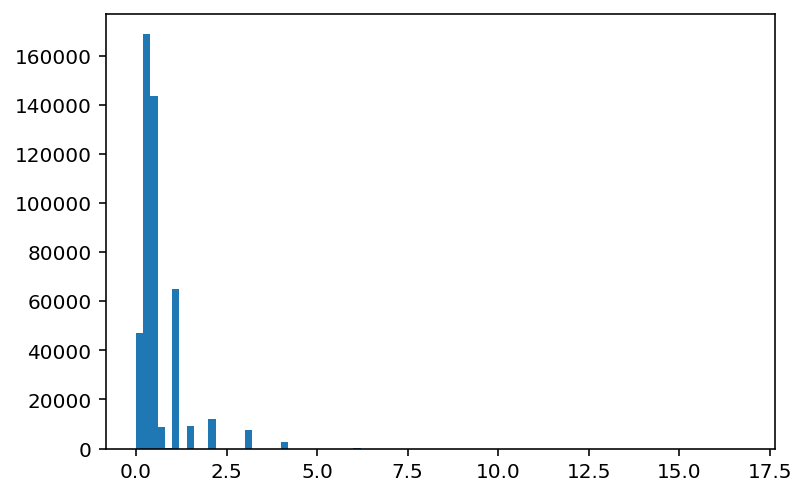

In [22]:
print(max(all_durations), min(all_durations))
plt.hist(all_durations, bins = np.arange(0,17,0.2))

## Produce lisp style (like original mdata) dataset from asap

In [60]:
asap_list_path = Path("./datasets/asap_lisp/")
asap_basepath = Path("../asap-dataset/")

In [61]:
# load the dataset info
df = pd.read_csv(Path(asap_basepath,'metadata.csv'))
df = df.drop_duplicates(subset=["title","composer"])

with open(Path(asap_basepath,'asap_annotations.json')) as json_file:
      json_data = json.load(json_file)

# accidentals_list = [list(json_data[m]["midi_score_key_signatures"].values())[0][1] for m  in df["midi_performance"]]
xml_score_paths = list(df["xml_score"])

print("N of pieces: ", len(xml_score_paths))

N of pieces:  222


In [66]:
for ir,row in df.iterrows():
    path = row["xml_score"]
    title = row['title']
    composer = row['composer']
    print("About to process",path)
    score = m21.converter.parse(Path(asap_basepath,path))
    # onset, pitchname, duration, voice
    onsets = score2onsets(score)
    pitchnames = score2pitches_meredith(score)
    durations = score2durations(score)
    voices = [1 for d in durations] #all same voice
    out="("
    #append all information to the string
    for i,(o,p,d,v) in enumerate(zip(onsets,pitchnames,durations,voices)):
        out += '({} "{}" {} {}) '.format(o,p,d,v)
        if i%3 == 2:
            out += "\n"
    out = out[:-1]+")"
    #save file
    with open(Path(asap_list_path,composer+title+".opnd-m"), "w") as text_file:
        text_file.write(out)

About to process Bach/Fugue/bwv_846/xml_score.musicxml
About to process Bach/Fugue/bwv_848/xml_score.musicxml
About to process Bach/Fugue/bwv_854/xml_score.musicxml
About to process Bach/Fugue/bwv_856/xml_score.musicxml
About to process Bach/Fugue/bwv_857/xml_score.musicxml
About to process Bach/Fugue/bwv_858/xml_score.musicxml
About to process Bach/Fugue/bwv_860/xml_score.musicxml
About to process Bach/Fugue/bwv_862/xml_score.musicxml
About to process Bach/Fugue/bwv_863/xml_score.musicxml
About to process Bach/Fugue/bwv_864/xml_score.musicxml
About to process Bach/Fugue/bwv_865/xml_score.musicxml
About to process Bach/Fugue/bwv_866/xml_score.musicxml
About to process Bach/Fugue/bwv_867/xml_score.musicxml
About to process Bach/Fugue/bwv_868/xml_score.musicxml
About to process Bach/Fugue/bwv_870/xml_score.musicxml
About to process Bach/Fugue/bwv_873/xml_score.musicxml
About to process Bach/Fugue/bwv_874/xml_score.musicxml
About to process Bach/Fugue/bwv_875/xml_score.musicxml
About to p

About to process Chopin/Etudes_op_25/2/xml_score.musicxml
About to process Chopin/Etudes_op_25/4/xml_score.musicxml
About to process Chopin/Etudes_op_25/5/xml_score.musicxml
About to process Chopin/Etudes_op_25/8/xml_score.musicxml
About to process Chopin/Polonaises/53/xml_score.musicxml
About to process Chopin/Scherzos/20/xml_score.musicxml
About to process Chopin/Scherzos/31/xml_score.musicxml
About to process Chopin/Scherzos/39/xml_score.musicxml
About to process Chopin/Sonata_2/1st_no_repeat/xml_score.musicxml
About to process Chopin/Sonata_2/2nd/xml_score.musicxml
About to process Chopin/Sonata_2/3rd/xml_score.musicxml
About to process Chopin/Sonata_2/4th/xml_score.musicxml
About to process Chopin/Sonata_3/2nd/xml_score.musicxml
About to process Chopin/Sonata_3/3rd/xml_score.musicxml
About to process Chopin/Sonata_3/4th/xml_score.musicxml
About to process Debussy/Images_Book_1/1_Reflets_dans_lEau/xml_score.musicxml
About to process Debussy/Pour_le_Piano/1/xml_score.musicxml
About 

# Cluster durations

With jensks

In [7]:
import jenkspy

bach1_dur=np.array(full_dict_dataset[356]["duration"])
bach1_dur.shape
breaks = jenkspy.jenks_breaks(bach1_dur, nb_class=4)
print(breaks)
quantized_durations = np.digitize(bach1_dur,breaks)
print(Counter(quantized_durations))

NameError: name 'full_dict_dataset' is not defined

With min in Kernel density estimation

[ -7.39414529  -6.18446577  -6.28938514  -7.32994204  -8.15512303
  -8.87092851  -9.79566138  -9.48658201  -9.77270215  -9.84566173
 -10.56457362 -10.27221509 -10.33934578 -10.40660388 -10.25725337
 -11.73561594 -11.91448952 -11.8291786  -13.09026381 -16.63505016
 -14.42240169 -11.88977683 -11.84024384 -14.19890704 -18.96788508
 -16.61970284 -13.08681846 -11.50384459 -11.68468584 -12.44023605
 -12.67778796 -12.83896431 -15.29342712 -20.40470996 -19.75739506
 -14.91929678 -12.74653543 -13.2393301  -16.39768079 -22.22158747
 -28.78124225 -20.74618198 -15.21981797 -12.35900997 -12.16375799
 -14.63406203 -19.76992209 -27.57133817 -38.03831026 -51.17083837]
Minima: [ 979.59183673 1632.65306122 2122.44897959 2612.24489796 3102.04081633
 3918.36734694 5387.75510204 6530.6122449 ]


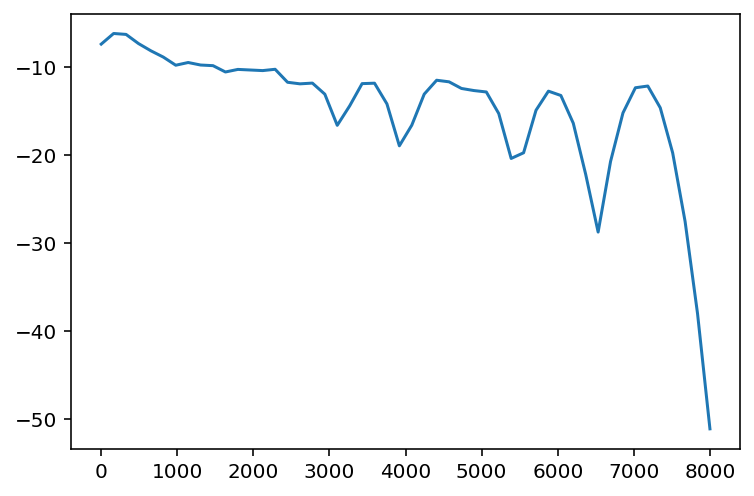

In [105]:
from sklearn.neighbors.kde import KernelDensity
from scipy.stats import gaussian_kde
from matplotlib.pyplot import plot, hist
from scipy.signal import argrelmin


with open('./datasets/musedata_noisy.pkl', 'rb') as fid:
     dataset_dict = pickle.load( fid)
# with open('./datasets/baroque_aug_asap.pkl', 'rb') as fid:
#      dataset_dict = pickle.load( fid)
        
a = np.array(dataset_dict[1]["duration"])
kde1 = KernelDensity(kernel='gaussian', bandwidth=100).fit(a.reshape(-1, 1))
kde2 = gaussian_kde(a,bw_method=0.1 )
s = np.linspace(0,8000)
e1 = kde1.score_samples(s.reshape(-1,1))
e2 = kde2.evaluate(s)

print(e1)
plot(s, e1)
# plot(s,e2)

min_indices = argrelmin(e1)
min_values = a[min_indices]
print("Minima:", s[min_indices])


With 1d kmeans

In [52]:
from sklearn.neighbors import KernelDensity
import pandas as pd

def plot_duration_clusters(data,clusters, centroids):
    # create a pandas dataframe
    temp_dict = {"duration":data, "cluster":clusters}
    temp_df = pd.DataFrame(temp_dict)
    #plot seaborn
    palette = sns.color_palette(palette="tab10",as_cmap=True)
    sns.kdeplot(data=temp_df, x="duration")
    sns.rugplot(data=temp_df, x="duration",hue ="cluster",height=.1, palette = "tab10" )
    #plot centroids
    for ic,cen in enumerate(centroids):
        plt.plot(cen,0,'ro') 

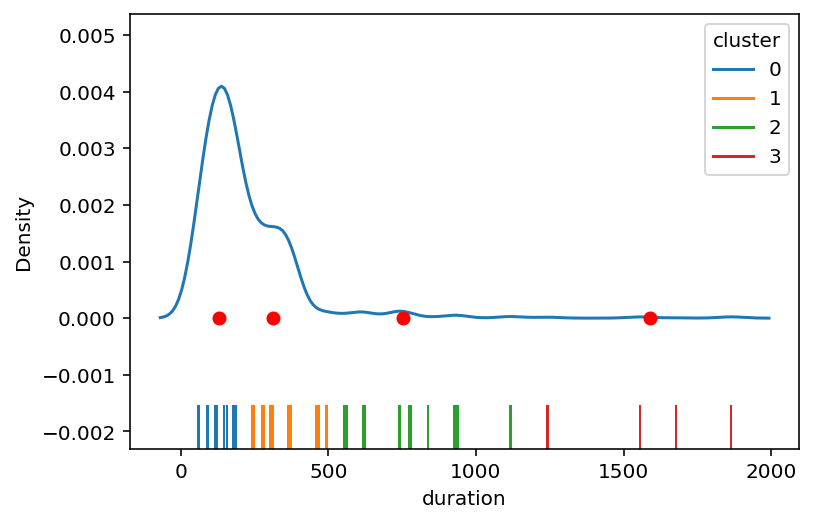

In [53]:
import kmeans1d
# with open('./datasets/aug_musedata.pkl', 'rb') as fid:
#      dataset_dict = pickle.load( fid)
with open('./datasets/musedata_noisy.pkl', 'rb') as fid:
     dataset_dict = pickle.load( fid)
# with open('./datasets/baroque_aug_asap.pkl', 'rb') as fid:
#      dataset_dict = pickle.load( fid)
        

a = np.array(dataset_dict[0]["duration"])
clusters, centroids = kmeans1d.cluster(a, 4)

plot_duration_clusters(a,clusters, centroids)

In [69]:
pitch30 = ['G', 'G', 'B', 'D', 'G', 'G', 'D', 'B', 'D', 'B', 'G', 'B', 'G', 'G', 'D', 'E', 'G', 'G', 'C', 'E', 'G', 'C', 'G', 'C', 'G', 'E', 'G', 'G', 'E', 'C']
[e["original_path"] for e in full_dict_dataset if e["pitches"][:30]==pitch30]

['Bach/Prelude/bwv_860/xml_score.musicxml']

In [72]:
len([e for e in dataset_dict if e["original_path"]== 'Bach/Prelude/bwv_860/xml_score.musicxml'
    and e["transposed_of"] == "P1"])

1